# importing libraries

In [ ]:
import os
import random
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import cv2
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data.dataset import Dataset
import pandas as pd
import matplotlib.pyplot as plt 
torch.backends.cudnn.benchmark=True


# downloading camvid dataset

In [ ]:
!gdown "https://s3.amazonaws.com/fast-ai-imagelocal/camvid.tgz"
!tar -xvzf /content/camvid.tgz
!gdown "http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/data/LabeledApproved_full.zip"
!gdown "http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/data/label_colors.txt"
!unzip  /content/LabeledApproved_full.zip -d LabeledApproved_full

Downloading...
From: https://s3.amazonaws.com/fast-ai-imagelocal/camvid.tgz
To: /content/camvid.tgz
100% 599M/599M [00:11<00:00, 50.8MB/s]
camvid/
camvid/codes.txt
camvid/images/
camvid/images/0016E5_00750.png
camvid/images/0006R0_f00990.png
camvid/images/0016E5_07410.png
camvid/images/Seq05VD_f00810.png
camvid/images/Seq05VD_f02280.png
camvid/images/0016E5_07987.png
camvid/images/0016E5_05040.png
camvid/images/0016E5_01560.png
camvid/images/0016E5_00780.png
camvid/images/0016E5_04380.png
camvid/images/0016E5_04830.png
camvid/images/0001TP_010110.png
camvid/images/0016E5_08430.png
camvid/images/0001TP_007410.png
camvid/images/0006R0_f03330.png
camvid/images/0016E5_06540.png
camvid/images/0016E5_01110.png
camvid/images/0001TP_008850.png
camvid/images/0001TP_007830.png
camvid/images/0006R0_f03570.png
camvid/images/Seq05VD_f05040.png
camvid/images/0001TP_009930.png
camvid/images/Seq05VD_f02400.png
camvid/images/Seq05VD_f03030.png
camvid/images/0016E5_02370.png
camvid/images/0016E5_08011.p

## color codecs of images

In [ ]:
import pandas as pd
labels = pd.read_csv('/content/label_colors.txt', sep=r"[ \t]+", names=['r', 'g', 'b', 'name'], header=None,index_col='name')
labels

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


,r,g,b
name,,,
Animal,64,128,64
Archway,192,0,128
Bicyclist,0,128,192
Bridge,0,128,64
Building,128,0,0
Car,64,0,128
CartLuggagePram,64,0,192
Child,192,128,64
Column_Pole,192,192,128


# preprocessing

## loading data and apply resize and local normalization

In [ ]:
cls2rgb = {cl:list(labels.loc[cl, :]) for cl in labels.index}
cls2rgb

{'Animal': [64, 128, 64],
 'Archway': [192, 0, 128],
 'Bicyclist': [0, 128, 192],
 'Bridge': [0, 128, 64],
 'Building': [128, 0, 0],
 'Car': [64, 0, 128],
 'CartLuggagePram': [64, 0, 192],
 'Child': [192, 128, 64],
 'Column_Pole': [192, 192, 128],
 'Fence': [64, 64, 128],
 'LaneMkgsDriv': [128, 0, 192],
 'LaneMkgsNonDriv': [192, 0, 64],
 'Misc_Text': [128, 128, 64],
 'MotorcycleScooter': [192, 0, 192],
 'OtherMoving': [128, 64, 64],
 'ParkingBlock': [64, 192, 128],
 'Pedestrian': [64, 64, 0],
 'Road': [128, 64, 128],
 'RoadShoulder': [128, 128, 192],
 'SUVPickupTruck': [64, 128, 192],
 'Sidewalk': [0, 0, 192],
 'SignSymbol': [192, 128, 128],
 'Sky': [128, 128, 128],
 'TrafficCone': [0, 0, 64],
 'TrafficLight': [0, 64, 64],
 'Train': [192, 64, 128],
 'Tree': [128, 128, 0],
 'Truck_Bus': [192, 128, 192],
 'Tunnel': [64, 0, 64],
 'VegetationMisc': [192, 192, 0],
 'Void': [0, 0, 0],
 'Wall': [64, 192, 0]}

In [ ]:
def load_input(folder_path):
  input = []
  image_filenames = sorted(glob(folder_path+'/*.png'))
  for i in image_filenames:
    rgb_img = cv2.imread(i)#.resize(225, 225)
    ycrcb_img = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2YCrCb)
    ycrcb_img[:, :, 0] = cv2.equalizeHist(ycrcb_img[:, :, 0])
    equalized_img = cv2.cvtColor(ycrcb_img, cv2.COLOR_YCrCb2BGR)
    equalized_img = equalized_img[:, :, [2, 1, 0]]
    equalized_img = cv2.resize(equalized_img, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)
    input.append(equalized_img)
    
  return np.array(input)



In [ ]:
def load_labeled_data(folder_path):
  input = []
  image_filenames = sorted(glob(folder_path+'/*.png'))
  for i in image_filenames:
    rgb_img = cv2.imread(i)#.resize(225, 225)
    rgb_img = rgb_img[:, :, [2, 1, 0]]
    rgb_img = cv2.resize(rgb_img, dsize=(256, 256))
    input.append(rgb_img)
  return np.array(input)


In [ ]:
input = load_input('/content/camvid/images')
masks = load_labeled_data('/content/LabeledApproved_full')

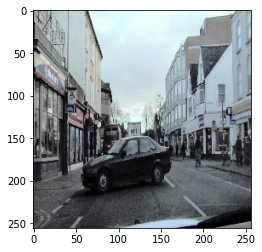

In [ ]:
plt.imshow(input[50])

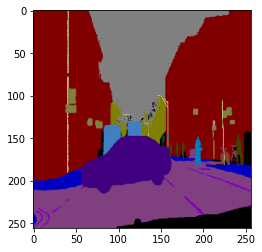

In [ ]:
plt.imshow(masks[50])

## creating labels

In [ ]:
idx2rgb=[np.array(rgb) for idx, (cl, rgb) in enumerate(cls2rgb.items())]
idx2rgb

[array([ 64, 128,  64]),
 array([192,   0, 128]),
 array([  0, 128, 192]),
 array([  0, 128,  64]),
 array([128,   0,   0]),
 array([ 64,   0, 128]),
 array([ 64,   0, 192]),
 array([192, 128,  64]),
 array([192, 192, 128]),
 array([ 64,  64, 128]),
 array([128,   0, 192]),
 array([192,   0,  64]),
 array([128, 128,  64]),
 array([192,   0, 192]),
 array([128,  64,  64]),
 array([ 64, 192, 128]),
 array([64, 64,  0]),
 array([128,  64, 128]),
 array([128, 128, 192]),
 array([  0,   0, 192]),
 array([192, 128, 128]),
 array([128, 128, 128]),
 array([ 64, 128, 192]),
 array([ 0,  0, 64]),
 array([ 0, 64, 64]),
 array([192,  64, 128]),
 array([128, 128,   0]),
 array([192, 128, 192]),
 array([64,  0, 64]),
 array([192, 192,   0]),
 array([0, 0, 0]),
 array([ 64, 192,   0])]

#### apply one hot encoding for each pixel

this function is from [this notebook](https://www.kaggle.com/drnykterstein/camvid-semantic-segmentation)

In [ ]:
def adjust_mask(mask):
    semantic_map = []
    for colour in list(cls2rgb.values()):        
        equality = np.equal(mask, colour)# 256x256x3 with True or False
        equality = np.all(equality, axis = -1)# 256x256 If all True, then True, else False
        semantic_map.append(equality)# List of 256x256 arrays, map of True for a given found color at the pixel, and False otherwise.
    semantic_map = np.stack(semantic_map, axis=-1)# 256x256x32 True only at the found color, and all False otherwise.

    return np.float32(semantic_map)# convert to numbers

In [ ]:
one_hot_masks = adjust_mask(masks)

In [ ]:
def conv_mask(masks):
  out = []
  for mask in masks:
    out.append(np.argmax(mask, axis=-1))
  return np.array(out)

In [ ]:
rgb_mask = conv_mask(one_hot_masks)

In [ ]:
del one_hot_masks

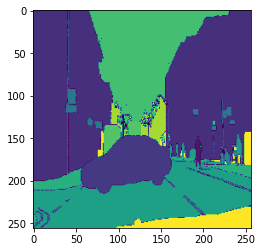

In [ ]:
plt.imshow(rgb_mask[50])

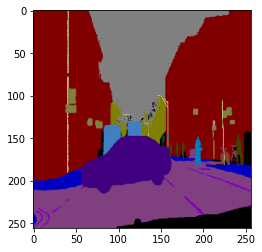

In [ ]:
plt.imshow(masks[50])

## split data to tain and test and validation

In [ ]:
train_data = []
for i in range(len(input)):
   train_data.append([input[i], rgb_mask[i], masks[i]])
train,valid,test = torch.utils.data.random_split(train_data, [600,50,51])



In [ ]:
num_clients = 2
num_selected = 2
num_rounds = 20
epochs = 6
batch_size = 4

### Create dataloaders for each local Network

In [ ]:
# Dividing the training data into num_clients, with each client having equal number of images
traindata_split = torch.utils.data.random_split(train, [int(len(train) / num_clients) for _ in range(num_clients)])
train_loader = [torch.utils.data.DataLoader(x, batch_size=batch_size, shuffle=True) for x in traindata_split]

validloader = torch.utils.data.DataLoader(valid, shuffle=True, batch_size=batch_size)
testloader = torch.utils.data.DataLoader(test, shuffle=True, batch_size=batch_size)

# create model

In [ ]:
class SegNetBaseBatchNorm(nn.Module):
    def __init__(self, input_channel):
        super(SegNetBaseBatchNorm, self).__init__()

        batchNorm_momentum = 0.1

        self.conv1 = nn.Conv2d(input_channel, 64, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm2d(64, momentum= batchNorm_momentum)

        self.conv2 = nn.Conv2d(64, 64, kernel_size=7, padding=3)
        self.bn2 = nn.BatchNorm2d(64, momentum= batchNorm_momentum)

        self.conv3 = nn.Conv2d(64, 64, kernel_size=7, padding=3)
        self.bn3 = nn.BatchNorm2d(64, momentum= batchNorm_momentum)

        self.conv4 = nn.Conv2d(64, 64, kernel_size=7, padding=3)
        self.bn4 = nn.BatchNorm2d(64, momentum= batchNorm_momentum)

        self.conv_decode4 =  nn.Conv2d(64, 64, kernel_size=7, padding=3)
        self.bn_decode4 = nn.BatchNorm2d(64, momentum= batchNorm_momentum)

        self.conv_decode3 =  nn.Conv2d(64, 64, kernel_size=7, padding=3)
        self.bn_decode3 = nn.BatchNorm2d(64, momentum= batchNorm_momentum)

        self.conv_decode2 =  nn.Conv2d(64, 64, kernel_size=7, padding=3)
        self.bn_decode2 = nn.BatchNorm2d(64, momentum= batchNorm_momentum)

        self.conv_decode1 =  nn.Conv2d(64, 64, kernel_size=7, padding=3)
        self.bn_decode1 = nn.BatchNorm2d(64, momentum= batchNorm_momentum)
        
        self.dense_softmax_inner_prod = nn.Conv2d(64, 32, kernel_size=1)
      

    def forward(self, x):

        # Stage 1
        x1 = F.relu(self.bn1(self.conv1(x)))
        x1p, id1 = F.max_pool2d(x1,kernel_size=2, stride=2,return_indices=True)

        # Stage 2
        x2 = F.relu(self.bn2(self.conv2(x1p)))
        x2p, id2 = F.max_pool2d(x2,kernel_size=2, stride=2,return_indices=True)

        # Stage 3
        x3 = F.relu(self.bn3(self.conv3(x2p)))
        x3p, id3 = F.max_pool2d(x3,kernel_size=2, stride=2,return_indices=True)

        # Stage 4
        x4 = F.relu(self.bn4(self.conv4(x3p)))
        x4p, id4 = F.max_pool2d(x4,kernel_size=2, stride=2,return_indices=True)

        # Stage 4d
        x4d = F.max_unpool2d(x4p, id4, kernel_size=2, stride=2)
        x41 = self.bn_decode4(self.conv_decode4(x4d))

        # Stage 3d
        x3d = F.max_unpool2d(x41, id3, kernel_size=2, stride=2)
        x31 = self.bn_decode3(self.conv_decode3(x3d))

        # Stage 2d
        x2d = F.max_unpool2d(x31, id2, kernel_size=2, stride=2)
        x21 = self.bn_decode2(self.conv_decode2(x2d))

        # Stage 1d
        x1d = F.max_unpool2d(x21, id1, kernel_size=2, stride=2)
        x12d = self.bn_decode1(self.conv_decode1(x1d))
        x11d = self.dense_softmax_inner_prod(x12d)

        return x11d


## Functions For federated Learning

In [ ]:
def server_aggregate(global_model, client_models):
    """
    This function has aggregation method 'mean'
    """
    ### This will take simple mean of the weights of models ###
    global_dict = global_model.state_dict()
    for k in global_dict.keys():
      global_dict[k] = torch.stack([client_models[i].state_dict()[k].float() for i in range(len(client_models))], 0).mean(0)
    global_model.load_state_dict(global_dict)
    for model in client_models:
      model.load_state_dict(global_model.state_dict())

In [ ]:
def validation(model, validation_loader):
  """This function test the global model on test data and returns test loss and test accuracy """
  model.eval()
  running_valid_loss = 0
  with torch.no_grad():
    for data, target,_ in validation_loader:
    # get the inputs; data is a list of [inputs, labels]
      inputs, labels = data.to(device), target.to(device)
      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = model(inputs.permute((0,3,1,2)).float())
      outputs = outputs.view(outputs.size(0),outputs.size(1), -1)
      outputs = torch.transpose(outputs,1,2).contiguous()
      outputs = outputs.view(-1,outputs.size(2))

      loss = criterion(outputs, labels.reshape(-1))
      running_valid_loss += loss.item()

    val_loss = running_valid_loss / len(validation_loader.dataset)

  return val_loss

In [ ]:
def client_update(model, optimizer, train_loader, epoch=5):
    """
    This function updates/trains client model on client data
    """
    model.train()
    for e in range(epoch):
        for batch_idx, (data, target,_) in enumerate(train_loader):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data.to(device), target.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs.permute((0,3,1,2)).float())
            outputs = outputs.view(outputs.size(0),outputs.size(1), -1)
            outputs = torch.transpose(outputs,1,2).contiguous()
            outputs = outputs.view(-1,outputs.size(2))

            loss = criterion(outputs, labels.reshape(-1))
            loss.backward()
            optimizer.step() 
    return loss.item()

# Trainining

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


## Define Global Network

In [ ]:
import torch.optim as optim
global_model = SegNetBaseBatchNorm(3).to(device)
torch.manual_seed(0)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(global_model.parameters(), lr=0.001, momentum=0.9, weight_decay= 0.0005)

## Define 2 Local Networks

In [ ]:

############## client models ##############
client_models = [ SegNetBaseBatchNorm(3).to(device) for _ in range(num_selected)]
for model in client_models:
    model.load_state_dict(global_model.state_dict()) ### initial synchronizing with global model 

############### optimizers ################
opt = [optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay= 0.0005) for model in client_models]

In [ ]:
###### List containing info about learning #########
losses_train = []
losses_val = []
acc_train = []
acc_test = []
# Runnining FL

for r in range(14):
    # select random clients
    client_idx = np.random.permutation(num_clients)[:num_selected]
    # client update
    loss = 0
    for i in tqdm(range(num_selected)):
        loss += client_update(client_models[i], opt[i], train_loader[client_idx[i]], epoch=epochs)
        torch.save(client_models[i].state_dict(), f'/content/local_model{i}.pth')
    
    losses_train.append(loss)
    # server aggregate
    server_aggregate(global_model, client_models)
    torch.save(global_model.state_dict(), f'/content/global_model.pth')
    val_loss = validation(global_model, validloader)
    losses_val.append(val_loss)
    #acc_test.append(acc)
    print('%d-th round' % r)
    print('average train loss %0.3g | test loss %0.3g ' % (loss / num_selected, val_loss))

100%|██████████| 2/2 [10:24<00:00, 312.12s/it]


0-th round
average train loss 1.12 | test loss 0.315 


100%|██████████| 2/2 [10:12<00:00, 306.21s/it]


1-th round
average train loss 0.987 | test loss 0.245 


100%|██████████| 2/2 [10:12<00:00, 306.19s/it]


2-th round
average train loss 0.829 | test loss 0.228 


100%|██████████| 2/2 [10:09<00:00, 304.75s/it]


3-th round
average train loss 0.854 | test loss 0.217 


100%|██████████| 2/2 [10:12<00:00, 306.38s/it]


4-th round
average train loss 0.735 | test loss 0.21 


100%|██████████| 2/2 [10:12<00:00, 306.21s/it]


5-th round
average train loss 0.698 | test loss 0.198 


100%|██████████| 2/2 [10:12<00:00, 306.31s/it]


6-th round
average train loss 0.656 | test loss 0.188 


100%|██████████| 2/2 [10:12<00:00, 306.29s/it]


7-th round
average train loss 0.658 | test loss 0.182 


100%|██████████| 2/2 [10:12<00:00, 306.31s/it]


8-th round
average train loss 0.525 | test loss 0.187 


100%|██████████| 2/2 [10:12<00:00, 306.25s/it]


9-th round
average train loss 0.496 | test loss 0.175 


100%|██████████| 2/2 [10:12<00:00, 306.32s/it]


10-th round
average train loss 0.496 | test loss 0.18 


100%|██████████| 2/2 [10:11<00:00, 305.66s/it]


11-th round
average train loss 0.535 | test loss 0.171 


100%|██████████| 2/2 [10:09<00:00, 304.72s/it]


12-th round
average train loss 0.495 | test loss 0.174 


100%|██████████| 2/2 [10:08<00:00, 304.48s/it]


13-th round
average train loss 0.421 | test loss 0.167 


# Test the Global Model

In [ ]:
def plot_test(model, testloader):

  # Map the idx back to rgb
  def map_class_to_rgb(p):
    return idx2rgb[p[0]]

  fig=plt.figure(figsize=(12, 35))
  #testloader = torch.utils.data.DataLoader(test)
  out=[]
  test_img = []
  test_label = []
  j=0
  #select 10 images
  for i in testloader:
    if j ==10:
      break
    test_,test_lbl = i[0],i[2]
    torch.cuda.empty_cache()
    out1 = model(test_.permute((0,3,1,2)).float().to(device))
    torch.cuda.empty_cache()
    out.append(out1)
    test_img.append(test_[0])
    test_label.append(test_lbl[0])
    j+=1
  i=0
  j=0
  for i in range(9):
    j+=1
    #print(out[0].size())
    rgbb_mask = np.apply_along_axis(map_class_to_rgb, -1, np.expand_dims(np.argmax(out[i].permute(0,2,3,1).cpu().detach().numpy(), axis=-1), -1))
    fig.add_subplot(9, 3, j)
    plt.title('Network Output')
    plt.imshow(rgbb_mask[0])
    j+=1
    fig.add_subplot(9, 3, j)
    plt.title('real image')
    plt.imshow(test_img[i])
    j+=1
    fig.add_subplot(9, 3, j)
    plt.title("real segmentation")
    plt.imshow(test_label[i])

  plt.show()



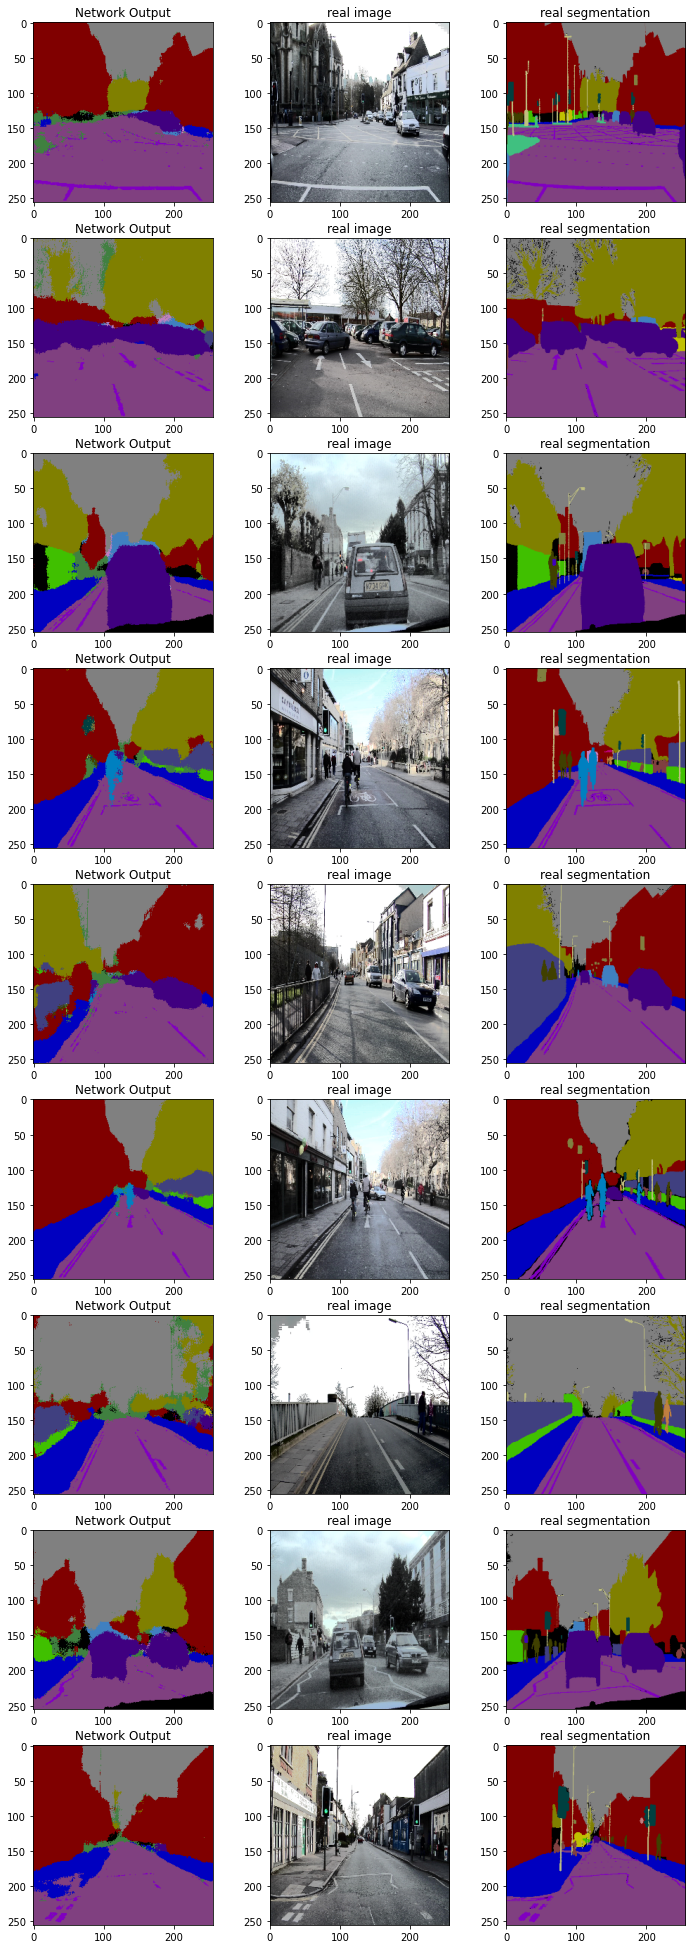

In [ ]:
plot_test(global_model, testloader)

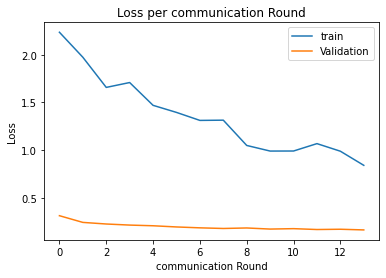

In [ ]:

plt.plot(losses_train, label='train')
plt.plot(losses_val, label='Validation')
plt.title("Loss per communication Round")
plt.xlabel("communication Round")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Define 3 local Networks

In [ ]:
num_clients = 3
num_selected = 2
num_rounds = 20
epochs = 6
batch_size = 4

In [ ]:
# Dividing the training data into num_clients, with each client having equal number of images
traindata_split = torch.utils.data.random_split(train, [int(len(train) / num_clients) for _ in range(num_clients)])
train_loader = [torch.utils.data.DataLoader(x, batch_size=batch_size, shuffle=True) for x in traindata_split]

validloader = torch.utils.data.DataLoader(valid, shuffle=True, batch_size=batch_size)
testloader = torch.utils.data.DataLoader(test, shuffle=True, batch_size=batch_size)

In [ ]:
import torch.optim as optim
global_model = SegNetBaseBatchNorm(3).to(device)
torch.manual_seed(0)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(global_model.parameters(), lr=0.001, momentum=0.9, weight_decay= 0.0005)

In [ ]:
#global_model = SegNetBaseBatchNorm(3).to(device)

############## client models ##############
client_models = [ SegNetBaseBatchNorm(3).to(device) for _ in range(num_selected)]
for model in client_models:
    model.load_state_dict(global_model.state_dict()) ### initial synchronizing with global model 

############### optimizers ################
opt = [optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay= 0.0005) for model in client_models]

In [ ]:
###### List containing info about learning #########
losses_train = []
losses_val = []
acc_train = []
acc_test = []
# Runnining FL

for r in range(14):
    # select random clients
    client_idx = np.random.permutation(num_clients)[:num_selected]
    # client update
    loss = 0
    for i in tqdm(range(num_selected)):
        loss += client_update(client_models[i], opt[i], train_loader[client_idx[i]], epoch=epochs)
        torch.save(client_models[i].state_dict(), f'/content/local_model{i}.pth')
    
    losses_train.append(loss)
    # server aggregate
    server_aggregate(global_model, client_models)
    torch.save(global_model.state_dict(), f'/content/global_model.pth')
    val_loss = validation(global_model, validloader)
    losses_val.append(val_loss)
    #acc_test.append(acc)
    print('%d-th round' % r)
    print('average train loss %0.3g | test loss %0.3g ' % (loss / num_selected, val_loss))

100%|██████████| 2/2 [06:43<00:00, 201.83s/it]


0-th round
average train loss 1.22 | test loss 0.345 


100%|██████████| 2/2 [06:28<00:00, 194.44s/it]


1-th round
average train loss 1.22 | test loss 0.287 


100%|██████████| 2/2 [06:28<00:00, 194.48s/it]


2-th round
average train loss 0.897 | test loss 0.257 


100%|██████████| 2/2 [06:32<00:00, 196.10s/it]


3-th round
average train loss 0.882 | test loss 0.25 


100%|██████████| 2/2 [06:33<00:00, 196.82s/it]


4-th round
average train loss 0.847 | test loss 0.244 


100%|██████████| 2/2 [06:28<00:00, 194.41s/it]


5-th round
average train loss 0.844 | test loss 0.224 


100%|██████████| 2/2 [06:29<00:00, 194.53s/it]


6-th round
average train loss 0.805 | test loss 0.217 


100%|██████████| 2/2 [06:32<00:00, 196.05s/it]


7-th round
average train loss 0.585 | test loss 0.21 


100%|██████████| 2/2 [06:33<00:00, 196.78s/it]


8-th round
average train loss 0.615 | test loss 0.206 


100%|██████████| 2/2 [06:28<00:00, 194.26s/it]


9-th round
average train loss 0.705 | test loss 0.198 


100%|██████████| 2/2 [06:28<00:00, 194.41s/it]


10-th round
average train loss 0.617 | test loss 0.19 


100%|██████████| 2/2 [06:31<00:00, 195.76s/it]


11-th round
average train loss 0.544 | test loss 0.193 


100%|██████████| 2/2 [06:33<00:00, 196.58s/it]


12-th round
average train loss 0.664 | test loss 0.183 


100%|██████████| 2/2 [06:28<00:00, 194.20s/it]


13-th round
average train loss 0.615 | test loss 0.18 


In [ ]:
def plot_test(model, testloader):

  # Map the idx back to rgb
  def map_class_to_rgb(p):
    return idx2rgb[p[0]]

  fig=plt.figure(figsize=(12, 35))
  #testloader = torch.utils.data.DataLoader(test)
  out=[]
  test_img = []
  test_label = []
  j=0
  #select 10 images
  for i in testloader:
    if j ==10:
      break
    test_,test_lbl = i[0],i[2]
    torch.cuda.empty_cache()
    out1 = model(test_.permute((0,3,1,2)).float().to(device))
    torch.cuda.empty_cache()
    out.append(out1)
    test_img.append(test_[0])
    test_label.append(test_lbl[0])
    j+=1
  i=0
  j=0
  for i in range(9):
    j+=1
    #print(out[0].size())
    rgbb_mask = np.apply_along_axis(map_class_to_rgb, -1, np.expand_dims(np.argmax(out[i].permute(0,2,3,1).cpu().detach().numpy(), axis=-1), -1))
    fig.add_subplot(9, 3, j)
    plt.title('Network Output')
    plt.imshow(rgbb_mask[0])
    j+=1
    fig.add_subplot(9, 3, j)
    plt.title('real image')
    plt.imshow(test_img[i])
    j+=1
    fig.add_subplot(9, 3, j)
    plt.title("real segmentation")
    plt.imshow(test_label[i])

  plt.show()



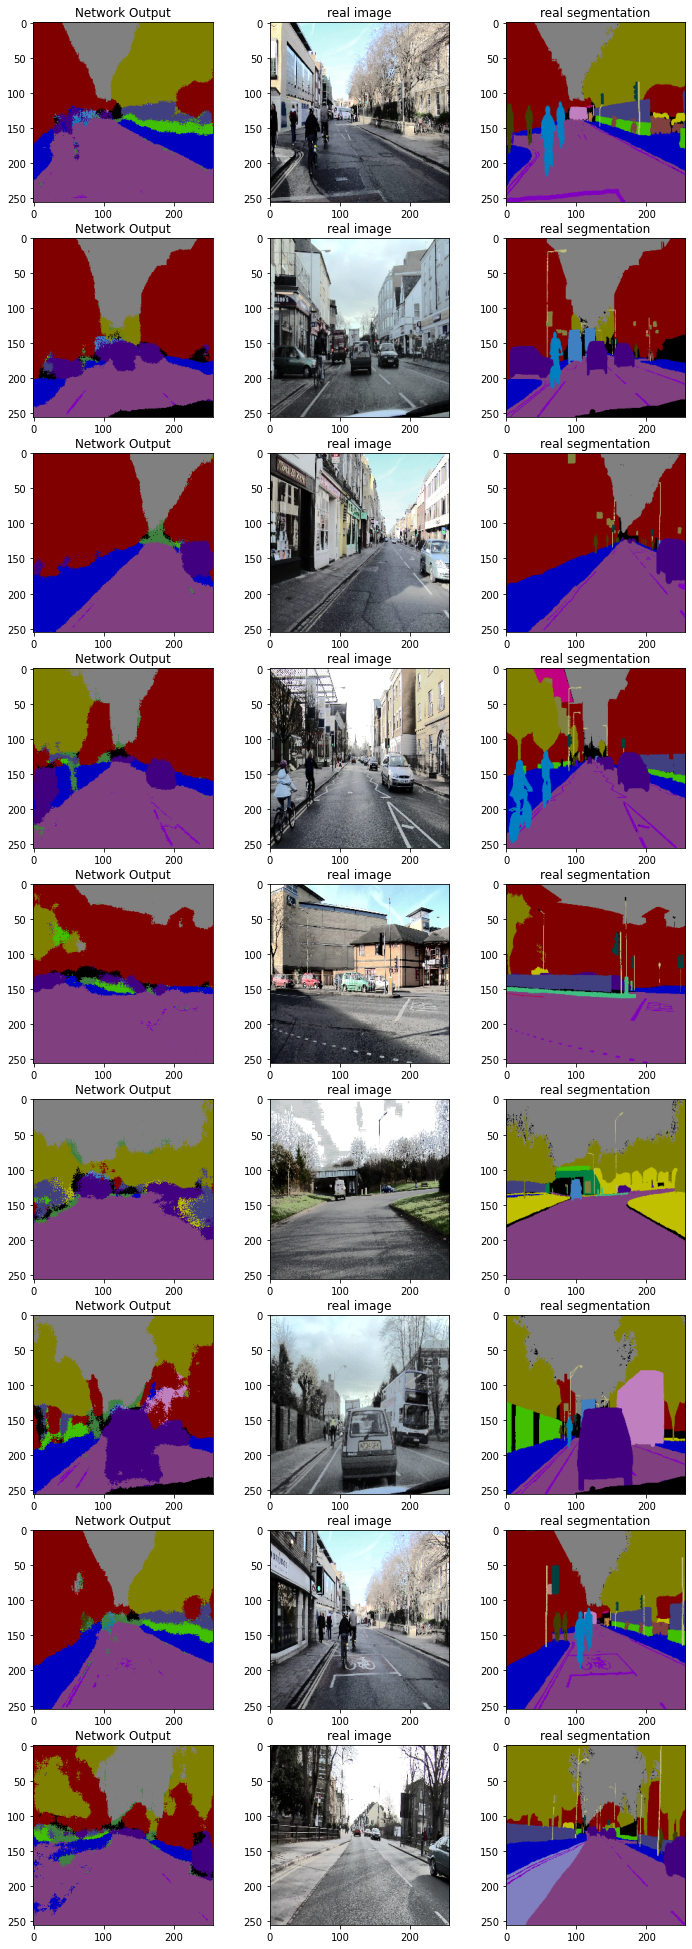

In [ ]:
plot_test(global_model, testloader)

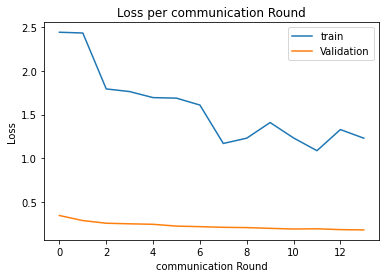

In [ ]:
plt.plot(losses_train, label='train')
plt.plot(losses_val, label='Validation')
plt.title("Loss per communication Round")
plt.xlabel("communication Round")
plt.ylabel("Loss")
plt.legend()
plt.show()